In [38]:
# importing libraries

import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image
import pandas as pd
import random
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.metrics import binary_crossentropy
from keras.optimizers import SGD
import tensorflow as tf
import seaborn as sns
from sklearn.metrics import confusion_matrix


In [39]:
# assigning data path
eyes = ['red_eye_aug','normal_eye_aug']

# data paths and number of images
train_data = './data/train/'
test_data = './data/test/'
val_data = './data/val/'
print('The train data contains ', len(os.listdir(train_data+'/'+eyes[1])), 'normal eye images and red eyes are ', len(os.listdir(train_data + '/' + eyes[0])))
print('The test data contains ', len(os.listdir(test_data+'/'+eyes[1])), 'normal eye images and red eyes are ', len(os.listdir(test_data + '/' + eyes[0])))
print('The val data contains ', len(os.listdir(val_data+'/'+eyes[1])), 'normal eye images and red eyes are ', len(os.listdir(val_data + '/' + eyes[0])))

The train data contains  475 normal eye images and red eyes are  474
The test data contains  5 normal eye images and red eyes are  6
The val data contains  85 normal eye images and red eyes are  84


In [40]:
# creating function to load images and labels 
def load_Images_And_Labels(data_path,eyes):
    X = []
    y = []
    i = 0
    for index,eye in enumerate (eyes):
        for img_name in os.listdir(data_path + '/' +eye):
            i =i+1
            img = cv2.imread(data_path + '/' + eye + '/' + img_name)
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Input must be a RGB image so converting BGR to RGB 
                img_array = Image.fromarray(img)
                image_resize = img_array.resize((227,227))   
                image_resize = np.array(image_resize)

                X.append(image_resize)
                y.append(index)
    return X,y

In [42]:
X_train, y_train = load_Images_And_Labels(train_data, eyes)
X_test, y_test = load_Images_And_Labels(test_data, eyes)
X_val, y_val = load_Images_And_Labels(val_data, eyes)

In [43]:
# Creating data dictionary
data_dictionary = {'X_train' : X_train,
                    'y_train' : y_train,
                    'X_test' : X_test,
                    'y_test' : y_test,
                    }

# save the dictionary into numpy array
np.save('data_dictionary.npy',data_dictionary)

In [44]:
#  loading data from the dictionary
data_dictionary_ = np.load('data_dictionary.npy',allow_pickle=True,).item()
X_train = data_dictionary_['X_train']
y_train = data_dictionary_['y_train']
X_test = data_dictionary_['X_test']
y_test = data_dictionary_['y_test']

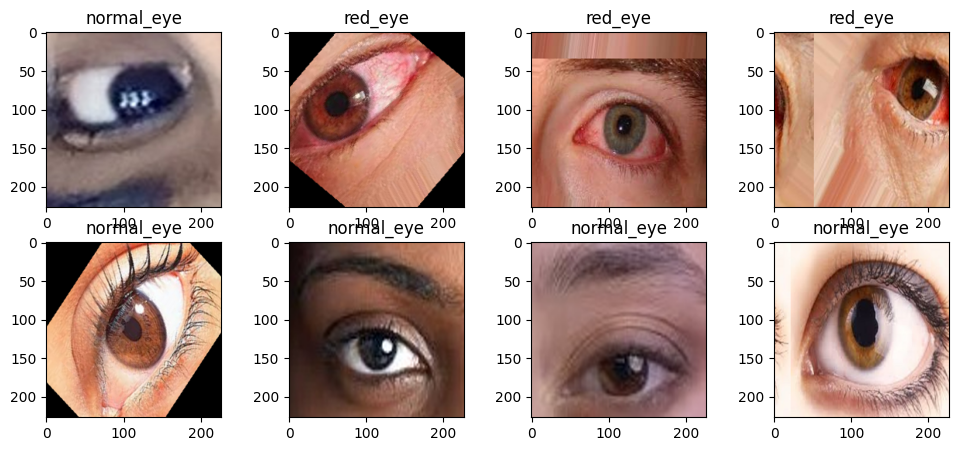

In [46]:
plt.figure(figsize = (12,5))
eye = ['red_eye', 'normal_eye']
for i in range(8):
  ind = random.randrange(0, len(X_train))
  plt.subplot(240 + 1 + i)
  plt.imshow(X_train[ind])
  plt.title(eye[y_train[ind]])

In [13]:
def preprocess_data(X, y):
  # convert X from list to array
  X = np.array(X)
  
  # convert integer values of X into floats
  X = X.astype(np.float32)

  # normalization 
  X = X/255.0
  
  # one-hot encoding the labels 
  y = to_categorical(np.array(y))
    
  return X, y
  
(X_train, y_train) = preprocess_data(X_train, y_train)
(X_test, y_test) = preprocess_data(X_test, y_test)

In [14]:
def Alexnet():
  # Initialize the model
  model = Sequential()

  # layer 1: convolutional layer + max-pooling layer
  model.add(Conv2D(filters = 96, kernel_size = (11,11), strides= 4, padding = 'valid', 
                   activation='relu', input_shape = (227,227,3)))
  model.add(MaxPooling2D(pool_size = (3,3), strides = 2))

  # layer 2: convolutional layer + max-pooling layer 
  model.add(Conv2D(filters = 256, kernel_size = (5,5), padding = 'same', 
                   activation = 'relu'))
  model.add(MaxPooling2D(pool_size = (3,3), strides = 2))

  # layers 3-5: three convolutional layers + 1 max-pooling layer
  model.add(Conv2D(filters = 384, kernel_size = (3,3), padding = 'same', 
                   activation = 'relu'))
  model.add(Conv2D(filters = 384, kernel_size = (3,3), padding = 'same', 
                   activation = 'relu'))
  model.add(Conv2D(filters = 256, kernel_size = (3,3), padding = 'same', 
                   activation = 'relu'))
  model.add(MaxPooling2D(pool_size = (3,3), strides = 2))

  # layers 6 - 8: two fully connected hidden layers and one fully connected output layer
  model.add(Flatten())
  model.add(Dense(4096, activation = 'relu'))
  #model.add(Dropout(0.5))
  model.add(Dense(4096, activation = 'relu'))
  #model.add(Dropout(0.5))
  model.add(Dense(2, activation = 'sigmoid'))

  # compile the model with a loss funciton, a metric and and optimizqation method
  opt = SGD(learning_rate = 0.1)
  model.compile(loss = binary_crossentropy,
                optimizer = opt,
                metrics = ['accuracy'])

  return model

In [15]:
Alexnet_model = Alexnet()
Alexnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 55, 55, 96)        34944     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 256)       614656    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 13, 256)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 13, 13, 384)       885120    
                                                                 
 conv2d_3 (Conv2D)           (None, 13, 13, 384)       1

In [16]:
# train the model
def train_model(model, X_train, y_train, X_test, y_test, epochs, batch_size):
  # Data generator
  datagen = ImageDataGenerator(rotation_range = 5, width_shift_range = 0.1, 
                               height_shift_range = 0.1, horizontal_flip = True)
  # iteration on the training set
  it_train = datagen.flow(X_train, y_train, batch_size = batch_size)
  # path to save the checkpoint 
  path_cp = os.getcwd() + '/' + 'weights_.hdf5'
  checkpoint_ = ModelCheckpoint(path_cp, monitor = 'loss', save_best_only = True, 
                                mode = 'auto')
  steps = X_train.shape[0]//batch_size
  # Fitting the model
  history = model.fit(it_train, epochs = epochs, steps_per_epoch = steps, 
                                validation_data = (X_test, y_test), verbose = 1, 
                                callbacks = checkpoint_)
  # Evaluating the model
  _, acc = model.evaluate(X_test, y_test, verbose = 1)
  print('%.3f' % (acc * 100.0))
  
  return history, acc

train_history, acc = train_model(Alexnet_model, X_train, y_train, X_test, y_test, 
                                 epochs = 100, batch_size = 120)

Epoch 1/100
7/7 [==============================] - 40s 6s/step - loss: 0.6930 - accuracy: 0.5042 - val_loss: 0.6916 - val_accuracy: 0.7273
Epoch 2/100
7/7 [==============================] - 48s 7s/step - loss: 0.6909 - accuracy: 0.5271 - val_loss: 0.6914 - val_accuracy: 0.4545
Epoch 3/100
7/7 [==============================] - 58s 8s/step - loss: 0.6885 - accuracy: 0.5356 - val_loss: 0.6883 - val_accuracy: 0.7273
Epoch 4/100
7/7 [==============================] - 50s 7s/step - loss: 0.6865 - accuracy: 0.5513 - val_loss: 0.6897 - val_accuracy: 0.5455
Epoch 5/100
7/7 [==============================] - 46s 6s/step - loss: 0.6838 - accuracy: 0.5489 - val_loss: 0.6948 - val_accuracy: 0.4545
Epoch 6/100
7/7 [==============================] - 47s 7s/step - loss: 0.6902 - accuracy: 0.6043 - val_loss: 0.6801 - val_accuracy: 0.7273
Epoch 7/100
7/7 [==============================] - 45s 6s/step - loss: 0.6896 - accuracy: 0.5621 - val_loss: 0.6781 - val_accuracy: 0.5455
Epoch 8/100
7/7 [==========

In [18]:
Alexnet_model.save('Alexnet_model.h5')

In [22]:
# convert the history.history to a pandas DataFrame:     
train_hist_df = pd.DataFrame(train_history.history) 

train_dict = {'train_hist': train_hist_df, 
              'acc': acc}
np.save('train_dict.npy', train_dict)  

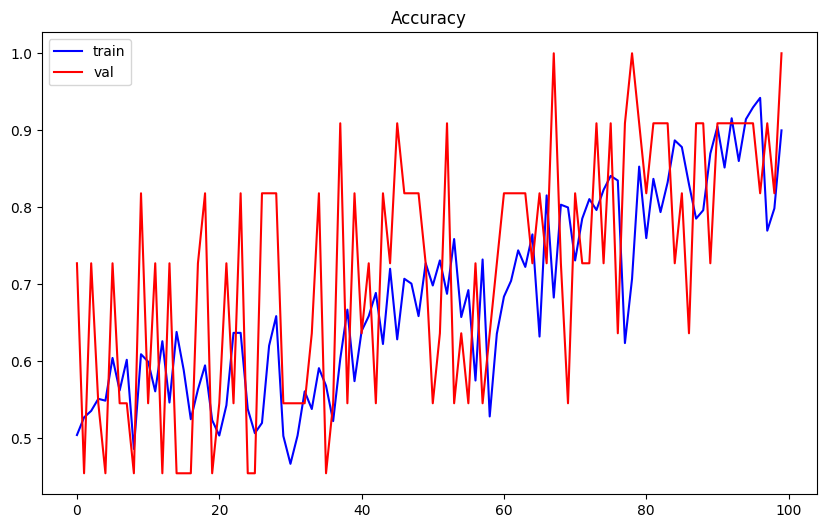

In [23]:
def plot_accuracy(history):
  plt.figure(figsize = (10,6))
  plt.plot(history.history['accuracy'], color = 'blue', label = 'train')
  plt.plot(history.history['val_accuracy'], color = 'red', label = 'val')
  plt.legend()
  plt.title('Accuracy')
  plt.show()
  
plot_accuracy(train_history)

In [24]:
y_test_pred = []
for i in np.arange(len(X_test)):
  img = X_test[i]
  img = img.reshape(1, 227, 227, 3)
  y_p = Alexnet_model.predict(img)
  y_test_pred.append(y_p)

y_test_pred = np.asarray(y_test_pred)

1/1 [==============================] - 0s 46ms/step


Text(95.72222222222221, 0.5, 'True classes')

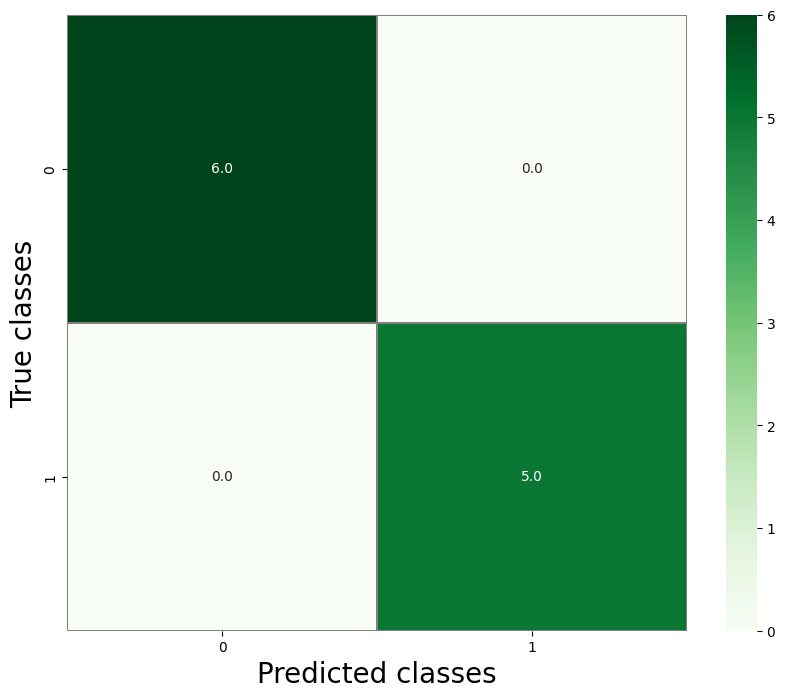

In [37]:
# Reverse the true and the predicted labels into the original binary 
# labels (0 and 1) to compute the confusion matrix
y_test_labels = [np.argmax(vect) for vect in y_test]
y_test_pred_labels = [np.argmax(vect) for vect in y_test_pred]

conf_mat = confusion_matrix(y_test_labels, y_test_pred_labels)

plt.figure(figsize = (10,8))
sns.heatmap(conf_mat, linewidths = 0.1, cmap = 'Greens', linecolor = 'gray', 
            fmt = '.1f', annot = True)
plt.xlabel('Predicted classes', fontsize = 20)
plt.ylabel('True classes', fontsize = 20)

1/1 [==============================] - 0s 57ms/step


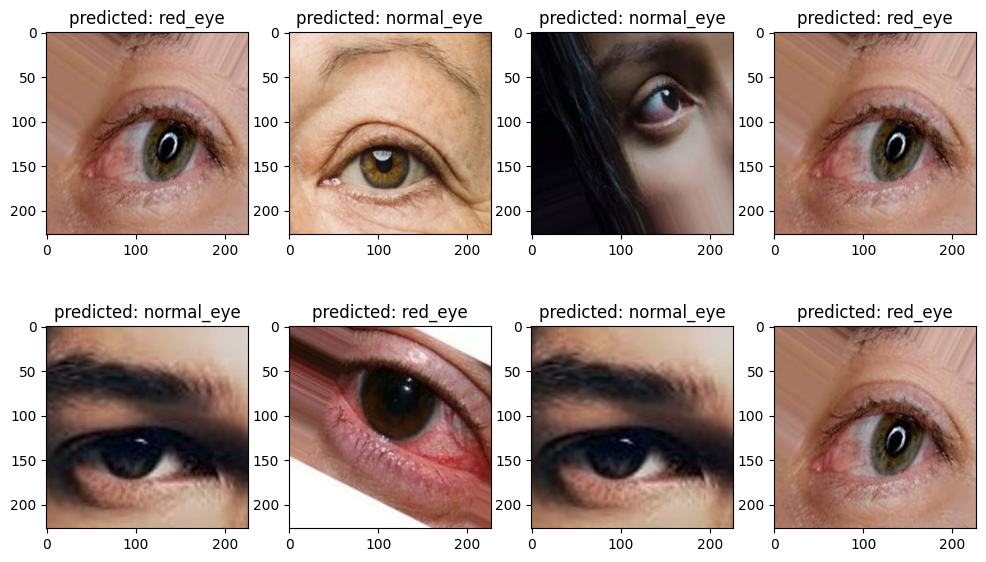

In [60]:
plt.figure(figsize = (12,7))
for i in np.arange(8):
  # take randomly an indice
  ind = random.randint(0, len(X_test))
  img = X_test[ind]
  # reshape the image 
  img_rs = img.reshape(1,227,227,3)
  # predict the label of img
  y_pred = Alexnet_model.predict(img_rs)
  # determine the corresponding category
  predicted_eye = eye[np.argmax(y_pred)]
  plt.subplot(240+1+i)
  plt.imshow(img)
  plt.title('predicted: ' + str(predicted_eye))

1/1 [==============================] - 0s 53ms/step


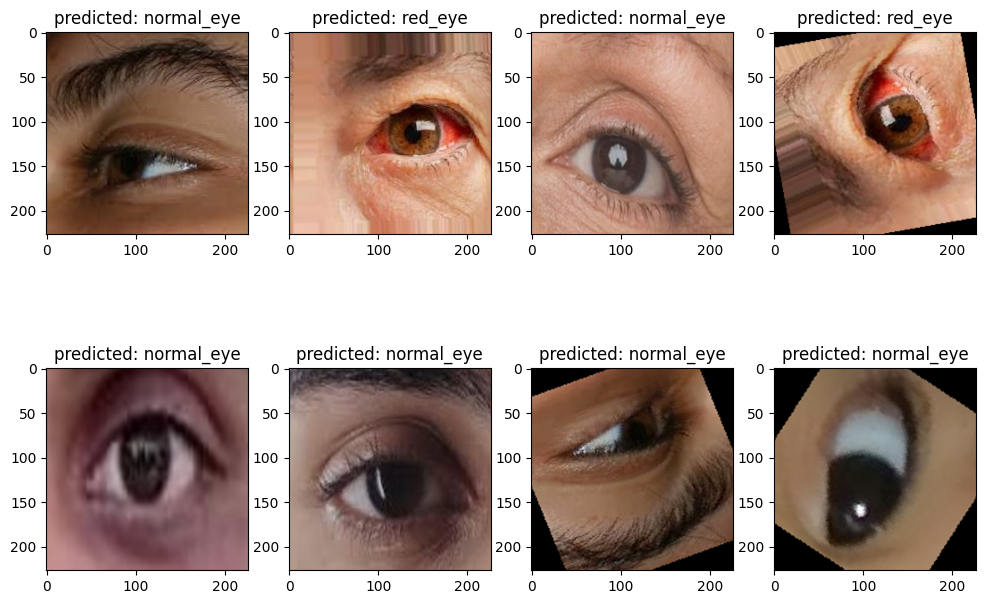

In [61]:
plt.figure(figsize = (12,8))
for i in np.arange(8):
  # take randomly an indice
  ind = random.randint(0, len(X_val))
  img = X_val[ind]
  # reshape the image 
  img_rs = img.reshape(1,227,227,3)
  # predict the label of img
  y_pred = Alexnet_model.predict(img_rs)
  # determine the corresponding category
  predicted_eye = eye[np.argmax(y_pred)]
  plt.subplot(240+1+i)
  plt.imshow(img)
  plt.title('predicted: ' + str(predicted_eye))

(0.0, 1.1)

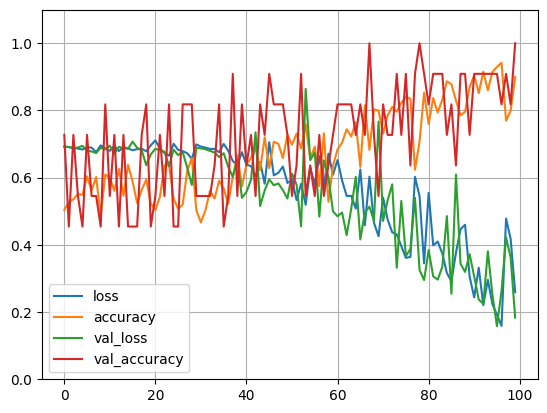

In [71]:
train_hist_df = pd.DataFrame(train_history.history) 
pd.DataFrame(train_history.history).plot()
plt.grid(True)
plt.gca().set_ylim(0,1.1) 